In [1]:
# %%
import os
import jax

# 设置环境变量
os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir=/usr/local/cuda"
os.environ["JAX_PLATFORM_NAME"] = "gpu"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

import os
os.environ['NETKET_EXPERIMENTAL_SHARDING'] = '1'

import netket as nk
import jax
print("启用分片模式：", nk.config.netket_experimental_sharding)
print("可用设备：", jax.devices())

启用分片模式： True
可用设备： [CudaDevice(id=0), CudaDevice(id=1)]


In [2]:
# %%
import os
import logging
import sys
import jax
import netket as nk
import numpy as np
import matplotlib.pyplot as plt
import time
import json
import netket.nn as nknn
import flax
import flax.linen as nn
import jax.numpy as jnp
import math
from math import pi
from functools import partial
from netket.nn import log_cosh
from einops import rearrange
from netket.utils.group.planar import rotation, reflection_group, D, glide, glide_group, C
from netket.utils.group import PointGroup, Identity, PermutationGroup
from netket.operator.spin import sigmax, sigmay, sigmaz
from netket.optimizer.qgt import QGTJacobianPyTree, QGTJacobianDense, QGTOnTheFly
from netket.operator import AbstractOperator
from netket.vqs import VariationalState
from scipy import sparse as _sparse
from netket.utils.types import DType as _DType
from netket.hilbert import DiscreteHilbert as _DiscreteHilbert
from netket.operator import LocalOperator as _LocalOperator
from tqdm.notebook import tqdm
from jax import tree
from netket.nn.blocks import SymmExpSum

In [3]:

# ----------------- CTWF模块定义 -----------------

# 多头自注意力模块（采用linear Q/K/V，加入Relative Positional Encoding）
class CTWF_MHSA(nn.Module):
    d_model: int         # total token dimension, i.e., 18
    h: int               # number of attention heads, i.e., 2
    L_eff: int           # sequence length (i.e., number of patches)
    
    def setup(self):
        self.d_head = self.d_model // self.h  # 9
        # Linear layers for Q, K, V
        self.linear_q = nn.Dense(features=self.h * self.d_head,
                                 kernel_init=nn.initializers.xavier_uniform(),
                                 param_dtype=jnp.float64, dtype=jnp.float64)
        self.linear_k = nn.Dense(features=self.h * self.d_head,
                                 kernel_init=nn.initializers.xavier_uniform(),
                                 param_dtype=jnp.float64, dtype=jnp.float64)
        self.linear_v = nn.Dense(features=self.h * self.d_head,
                                 kernel_init=nn.initializers.xavier_uniform(),
                                 param_dtype=jnp.float64, dtype=jnp.float64)
        # Output projection
        self.linear_out = nn.Dense(features=self.d_model,
                                   kernel_init=nn.initializers.xavier_uniform(),
                                   param_dtype=jnp.float64, dtype=jnp.float64)
        # Relative Positional Encoding, shape (L_eff, L_eff); note the initializer is now called
        self.P = self.param("P", nn.initializers.xavier_uniform(), (self.L_eff, self.L_eff), jnp.float64)

    def __call__(self, x):
        # x: [batch, L_eff, d_model]
        batch = x.shape[0]
        # Linear mapping
        Q = self.linear_q(x)  # [batch, L_eff, h*d_head]
        K = self.linear_k(x)
        V = self.linear_v(x)
        # Reshape to [batch, L_eff, h, d_head]
        Q = rearrange(Q, 'b L (h d) -> b L h d', h=self.h)
        K = rearrange(K, 'b L (h d) -> b L h d', h=self.h)
        V = rearrange(V, 'b L (h d) -> b L h d', h=self.h)
        # Transpose to [batch, h, L, d_head]
        Q = jnp.transpose(Q, (0, 2, 1, 3))
        K = jnp.transpose(K, (0, 2, 1, 3))
        V = jnp.transpose(V, (0, 2, 1, 3))
        # Compute attention logits: [batch, h, L, L] = Q*K^T/√d_head + P, where P is broadcasted
        scale = 1.0 / jnp.sqrt(self.d_head)
        attn_logits = jnp.einsum('bhid,bhjd->bhij', Q, K) * scale + self.P[None, None, :, :]
        attn_weights = nn.softmax(attn_logits, axis=-1)
        # Attention output: [batch, h, L, d_head]
        attn_out = jnp.einsum('bhij,bhjd->bhid', attn_weights, V)
        # Merge heads [batch, L, h*d_head]
        attn_out = jnp.transpose(attn_out, (0, 2, 1, 3))
        attn_out = rearrange(attn_out, 'b L h d -> b L (h d)')
        # Output projection
        out = self.linear_out(attn_out)
        return out


# 卷积单元，用于编码局部结构
class ConvUnit(nn.Module):
    d_model: int
    kernel_size: int = 3
    def setup(self):
        self.conv = nn.Conv(features=self.d_model,
                            kernel_size=(self.kernel_size,),
                            padding='SAME',
                            kernel_init=nn.initializers.xavier_uniform(),
                            param_dtype=jnp.float64, dtype=jnp.float64)
    def __call__(self, x):
        # x: [batch, L_eff, d_model]
        # 1D convolution沿着序列（token）维度：输入形状不改变
        return nn.gelu(self.conv(x))

# IRFFN模块，采用3层卷积，其中第二层为depthwise conv
class IRFFN(nn.Module):
    d_model: int
    expansion: int = 2   # 扩展因子
    kernel_size: int = 3
    def setup(self):
        self.conv1 = nn.Conv(features=self.expansion * self.d_model,
                             kernel_size=(1,),
                             kernel_init=nn.initializers.xavier_uniform(),
                             param_dtype=jnp.float64, dtype=jnp.float64)
        # depthwise conv：设置 feature_group_count = expansion*d_model
        self.conv2 = nn.Conv(features=self.expansion * self.d_model,
                             kernel_size=(self.kernel_size,),
                             padding='SAME',
                             feature_group_count=self.expansion * self.d_model,
                             kernel_init=nn.initializers.xavier_uniform(),
                             param_dtype=jnp.float64, dtype=jnp.float64)
        self.conv3 = nn.Conv(features=self.d_model,
                             kernel_size=(1,),
                             kernel_init=nn.initializers.xavier_uniform(),
                             param_dtype=jnp.float64, dtype=jnp.float64)
    def __call__(self, x):
        # x: [batch, L_eff, d_model]
        x_in = x
        x = self.conv1(x)
        x = nn.gelu(x)
        x = self.conv2(x)
        x = nn.gelu(x)
        x = self.conv3(x)
        return x + x_in

# 单个CTWF Block，包含Conv Unit、MHSA和IRFFN，每一部分均采用残差连接和前层归一化
class CTWFBlock(nn.Module):
    d_model: int   # 例如18
    h: int         # 例如2
    L_eff: int
    
    def setup(self):
        # 独立归一化层
        self.norm_conv = nn.LayerNorm(dtype=jnp.float64, param_dtype=jnp.float64)
        self.conv_unit = ConvUnit(self.d_model)  # 保持原来的卷积单元
        self.norm_mhsa = nn.LayerNorm(dtype=jnp.float64, param_dtype=jnp.float64)
        self.mhsa = CTWF_MHSA(d_model=self.d_model, h=self.h, L_eff=self.L_eff)
        self.norm_irffn = nn.LayerNorm(dtype=jnp.float64, param_dtype=jnp.float64)
        self.irffn = IRFFN(d_model=self.d_model, expansion=2)  # 如有需要，可调整expansion因子
    
    def __call__(self, x):
        # Conv Unit部分
        y = self.norm_conv(x)
        y = self.conv_unit(y)
        x = x + y
        # MHSA模块：独立归一化
        y = self.norm_mhsa(x)
        y = self.mhsa(y)
        x = x + y
        # IRFFN模块：独立归一化
        y = self.norm_irffn(x)
        y = self.irffn(y)
        return x + y

# 输出层模块，先对所有token求和后做线性映射，最后采用pair complex激活（使用log_cosh）
def log_cosh(x):
    sgn = 1.0 - 2.0 * jnp.heaviside(-jnp.real(x), 0.0)
    x = x * sgn
    return x + jnp.log1p(jnp.exp(-2.0*x)) - jnp.log(2.0)

class OutputHead(nn.Module):
    d_model: int
    complex_out: bool = True
    def setup(self):
        self.norm = nn.LayerNorm(dtype=jnp.float64, param_dtype=jnp.float64)
        # 两个全连接层分别得到振幅和相位（若complex_out为True）
        self.linear_amp = nn.Dense(features=self.d_model,
                                   kernel_init=nn.initializers.xavier_uniform(),
                                   param_dtype=jnp.float64, dtype=jnp.float64)
        self.linear_phase = nn.Dense(features=self.d_model,
                                     kernel_init=nn.initializers.xavier_uniform(),
                                     param_dtype=jnp.float64, dtype=jnp.float64)
    def __call__(self, x):
        # 对所有token求和后归一化
        z = self.norm(x.sum(axis=1))
        amp = self.linear_amp(z)
        if self.complex_out:
            phase = self.linear_phase(z)
            out = amp + 1j * phase
        else:
            out = amp
        # 最后沿着最后维度求log_cosh之和
        return jnp.sum(log_cosh(out), axis=-1)

# 整个CTWF量子态网络，包含patch嵌入、CTWF Block（此处只堆叠1层以达到参数7884左右，可根据需要增减）、输出头
class CTWFNQS(nn.Module):
    num_layers: int      # CTWF层数，设为1
    d_model: int         # 应设为18
    h: int               # 2
    n_sites: int         # 总格点数
    patch_size: int      # patch尺寸
    complex_out: bool = True
    two_dimensional: bool = True
    def setup(self):
        # 计算有效序列长度 L_eff = n_sites/(patch_size**2) (2d情况)
        if self.two_dimensional:
            self.L_eff = self.n_sites // (self.patch_size ** 2)
        else:
            self.L_eff = self.n_sites // self.patch_size
        # 嵌入层，将原始patch映射到d_model（18）维
        self.embed = nn.Dense(features=self.d_model,
                              kernel_init=nn.initializers.xavier_uniform(),
                              param_dtype=jnp.float64, dtype=jnp.float64)
        # 堆叠CTWF Block（这里一般堆叠1层可近似达到参数7884，否则参数会增加）
        self.blocks = [CTWFBlock(d_model=self.d_model, h=self.h, L_eff=self.L_eff)
                       for _ in range(self.num_layers)]
        self.out_head = OutputHead(d_model=self.d_model, complex_out=self.complex_out)
        
    def __call__(self, spins):
        # 保证输入为二维 [batch, n_sites]
        x = jnp.atleast_2d(spins)
        # Patch提取
        if self.two_dimensional:
            x = extract_patches2d(x, self.patch_size)
        else:
            x = extract_patches1d(x, self.patch_size)
        # 嵌入
        x = self.embed(x)
        # 逐层CTWF Block
        for block in self.blocks:
            x = block(x)
        out = self.out_head(x)
        return out

# Patch提取辅助函数
def extract_patches1d(x, b):
    return rearrange(x, 'batch (L_eff b) -> batch L_eff b', b=b)

def extract_patches2d(x, b):
    # 对二维，自适应计算patch数
    batch = x.shape[0]
    sq_L = int(np.sqrt(x.shape[1]))
    # 将n_sites reshape为 [batch, sq_L, sq_L]，再将每个 bxb patch展平
    new_shape = (batch, sq_L // b, b, sq_L // b, b)
    x = x.reshape(new_shape)
    x = x.transpose(0, 1, 3, 2, 4)
    x = x.reshape(batch, -1, b*b)
    return x


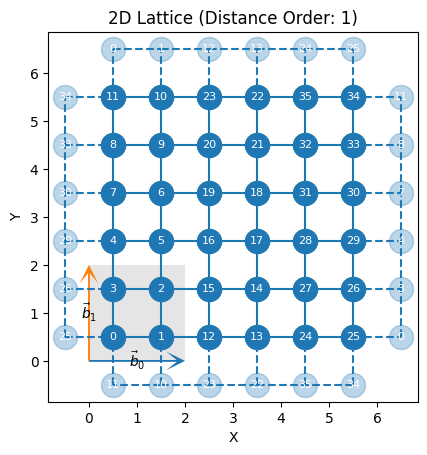

In [4]:
# %%
# 哈密顿量参数
J1 = 0.8
J2 = 1.0
Q = 0  # 四自旋相互作用强度，替换h项

# Shastry-Sutherland晶格定义
Lx = 3
Ly = 3

# 自定义边
custom_edges = [
    (0, 1, [1.0, 0.0], 0),
    (1, 0, [1.0, 0.0], 0),
    (1, 2, [0.0, 1.0], 0),
    (2, 1, [0.0, 1.0], 0),
    (3, 2, [1.0, 0.0], 0),
    (2, 3, [1.0, 0.0], 0),
    (0, 3, [0.0, 1.0], 0),
    (3, 0, [0.0, 1.0], 0),
    (2, 0, [1.0, -1.0], 1),
    (3, 1, [1.0, 1.0], 1),
]

# 创建晶格
lattice = nk.graph.Lattice(
    basis_vectors=[[2.0, 0.0], [0.0, 2.0]],
    extent=(Lx, Ly),
    site_offsets=[[0.5, 0.5], [1.5, 0.5], [1.5, 1.5], [0.5, 1.5]],
    custom_edges=custom_edges,
    pbc=[True, True]
)

# 可视化晶格
lattice.draw()

# %%
# Hilbert空间定义
hi = nk.hilbert.Spin(s=1/2, N=lattice.n_nodes, total_sz=0)

# 自旋-1/2矩阵
sigmax = jnp.array([[0, 0.5], [0.5, 0]])
sigmay = jnp.array([[0, -0.5j], [0.5j, 0]])
sigmaz = jnp.array([[0.5, 0], [0, -0.5]])
unitm = jnp.array([[1.0, 0.0], [0.0, 1.0]])

# 自旋-自旋相互作用
sxsx = np.kron(sigmax, sigmax)
sysy = np.kron(sigmay, sigmay)
szsz = np.kron(sigmaz, sigmaz)
umum = np.kron(unitm, unitm)
SiSj = sxsx + sysy + szsz

# Q项需要的C_ij算子定义
Cij = 0.25 * umum - SiSj
Cij2 = np.kron(Cij, Cij)  # 四自旋交互项

# 构建J1-J2部分的哈密顿量
bond_operator = [
    (J1 * SiSj).tolist(),
    (J2 * SiSj).tolist(),
]
bond_color = [0, 1]

# 创建图哈密顿量 - 不包含Q项
H_J = nk.operator.GraphOperator(hi, graph=lattice, bond_ops=bond_operator, bond_ops_colors=bond_color)

# 创建Q项哈密顿量
H_Q = nk.operator.LocalOperator(hi, dtype=jnp.complex128)

# 添加四自旋Q项 - 每个单元格(plaquette)上的四自旋相互作用
for unit_x in range(Lx):
    for unit_y in range(Ly):
        # 找到单元格中的4个顶点
        base_idx = 4 * (unit_x + unit_y * Lx)
        plaq_sites = [
            base_idx,                  # 左下角 (0.5, 0.5) 
            base_idx + 1,              # 右下角 (1.5, 0.5)
            base_idx + 2,              # 右上角 (1.5, 1.5)
            base_idx + 3               # 左上角 (0.5, 1.5)
        ]
        
        # 两种不同的顺序添加四自旋相互作用Q项
        # 按照顺时针方向连接
        sites_clockwise = [plaq_sites]
        operatorQ = [(-Q * Cij2).tolist()]
        H_Q += nk.operator.LocalOperator(hi, operatorQ, sites_clockwise)
        
        # 按照交叉方向连接
        sites_cross = [[plaq_sites[0], plaq_sites[2], plaq_sites[1], plaq_sites[3]]]
        H_Q += nk.operator.LocalOperator(hi, operatorQ, sites_cross)

# 合并两部分哈密顿量
ha = H_J + H_Q
ha = ha.to_jax_operator()

In [5]:
import time
import jax
import jax.numpy as jnp
from jax import tree_util
from tqdm.notebook import tqdm
from netket.experimental.driver.vmc_srt import VMC_SRt

# 定义熵梯度计算函数
def T_logp2(params, inputs, temperature, model_instance):
    variables = {"params": params}
    preds = model_instance.apply(variables, inputs)
    return 2.0 * temperature * jnp.mean(jnp.real(preds)**2)

def T_logp_2(params, inputs, temperature, model_instance):
    variables = {"params": params}
    preds = model_instance.apply(variables, inputs)
    return 2.0 * temperature * (jnp.mean(jnp.real(preds)))**2

# 基于 VMC_SRt 实现自由能 F = E - T*S 的优化
class FreeEnergyVMC_SRt(VMC_SRt):
    def __init__(self, temperature, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # 记录初始温度，用于后续温度递减计算
        self.init_temperature = temperature
        self.temperature = temperature

    def _step_with_state(self, state):
        # 基础能量梯度更新步骤
        new_state = super()._step_with_state(state)
        params = new_state.parameters
        inputs = new_state.samples
        
        # 计算熵梯度部分
        mT_grad_S_1 = jax.grad(T_logp2, argnums=0)(params, inputs, self.temperature, self.variational_state.model)
        mT_grad_S_2 = jax.grad(T_logp_2, argnums=0)(params, inputs, self.temperature, self.variational_state.model)
        mT_grad_S = tree_util.tree_map(lambda x, y: x - y, mT_grad_S_1, mT_grad_S_2)
        
        # 自由能梯度：能量梯度减去熵梯度
        total_grad = tree_util.tree_map(lambda g_e, g_s: g_e - g_s, new_state.gradient, mT_grad_S)
        
        # 更新参数
        new_params = self.optimizer.update(total_grad, params)
        new_state = new_state.replace(parameters=new_params)
        return new_state

# 添加进度条以及温度递减方案
class CustomFreeEnergyVMC_SRt(FreeEnergyVMC_SRt):
    def __init__(self, reference_energy, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.reference_energy = reference_energy

    def run(self, n_iter, out=None):
        """运行优化并在 tqdm 进度条中显示 Temperature，Energy，E_var，E_err 和 Rel_err(%)"""
        outer_pbar = tqdm(total=n_iter, desc=f"Lx={Lx}, Ly={Ly}")
        for i in range(n_iter):
            # 更新温度：使用初始温度乘以递减因子
            self.temperature = self.init_temperature * (jnp.exp(-i / 50.0) / 2.0)
            self.advance(1)

            energy_mean = self.energy.mean
            energy_var = self.energy.variance
            energy_error = self.energy.error_of_mean
            relative_error = abs((energy_mean - self.reference_energy) / self.reference_energy) * 100

            outer_pbar.set_postfix({
                'Temp': f'{self.temperature:.4f}',
                'Energy': f'{energy_mean:.6f}', 
                'E_var': f'{energy_var:.6f}',
                'E_err': f'{energy_error:.6f}',
                'Rel_err(%)': f'{relative_error:.4f}',
            })
            outer_pbar.update(1)
        outer_pbar.close()
        return self

In [ ]:
# 假设 lattice, hi, hamiltonian, model_no_symm, reference_energy 已经定义
n_samples = 2**12       # 采样数量
chunk_size = 2**8       # 批处理大小
learning_rate = 0.05
diag_shift = 0.001

# 创建采样器
sampler = nk.sampler.MetropolisExchange(hilbert=hi, graph=lattice, n_chains=2**12, d_max=2)


optimizer = nk.optimizer.Sgd(learning_rate=0.05)

In [ ]:
model_no_symm = CTWFNQS(
    num_layers=2,
    d_model=18,      # token embedding dimension = c=18
    h=2,             # 注意力头数=2，每头token维度 = 9
    n_sites=lattice.n_nodes,
    patch_size=2,
    complex_out=True,
    two_dimensional=True
)

In [ ]:
reference_energy=-16.18

In [ ]:
print("\n========== 阶段1: 平移对称性 ==========")
# 创建只有恒等操作的对称性组
trans_symmetry = lattice.translation_group()
print("平移对称群元素数量:", len(trans_symmetry))

# 使用SymmExpSum包装基础模型，只有恒等操作
model_stage1 = SymmExpSum(
    module=model_no_symm, 
    symm_group=trans_symmetry,
    character_id=None
)

vqs1 = nk.vqs.MCState(
    sampler=sampler,
    model=model_stage1,
    n_samples=n_samples,
    n_discard_per_chain=0,  # 丢弃初始样本以减少自相关性
    chunk_size=chunk_size,
    training_kwargs={"holomorphic": False}
)

# 假设已经定义了 CustomVMC_SRt 类，用于自定义变分 Monte Carlo 优化，可以直接使用
vmc1 = CustomFreeEnergyVMC_SRt(
    reference_energy=reference_energy,
    temperature=1.0,
    hamiltonian=ha,
    optimizer=optimizer,
    diag_shift=0.01,
    variational_state=vqs1
)

vmc1.run(n_iter=500)
energy1 = vmc1.energy.mean.real
print(f"阶段1完成，能量: {energy1:.6f}")



========== 阶段1: 平移对称性 ==========
平移对称群元素数量: 9


KeyboardInterrupt: 

In [ ]:
print("\n========== 阶段2: 添加D4对称性 ==========")
# 使用内置的 C4 对称群
d4_group = D(4)

# 定义新的对称中心
new_origin = np.array([3.0, 3.0])

# 调整对称群，以 new_origin 为新的旋转中心
new_d4_group = d4_group.change_origin(new_origin)
D4_symmetry = lattice.point_group(new_d4_group)
print("D4对称群元素数量:", len(D4_symmetry))

model_c4 = SymmExpSum(
    module=model_no_symm, 
    symm_group=D4_symmetry,
    character_id=None
)

vqs2 = nk.vqs.MCState(
    sampler=sampler,
    model=model_c4,
    n_samples=n_samples,
    n_discard_per_chain=0,
    chunk_size=chunk_size,
    training_kwargs={"holomorphic": False}
)

vqs2.parameters = vqs1.parameters
print("成功复制阶段1参数到阶段2")


vmc2 = CustomFreeEnergyVMC_SRt(
    reference_energy=reference_energy,
    temperature=1.0,
    hamiltonian=ha,
    optimizer=optimizer,
    diag_shift=diag_shift,
    variational_state=vqs2,
)

vmc2.run(n_iter=200)
energy3 = vmc2.energy.mean.real
print(f"阶段2完成，能量: {energy3:.6f}")



========== 阶段2: 添加D4对称性 ==========
D4对称群元素数量: 8
成功复制阶段1参数到阶段2


Lx=3, Ly=3:   0%|          | 0/200 [00:00<?, ?it/s]

KeyboardInterrupt: 